In [56]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [57]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [58]:
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4


In [59]:
waterDF['일자'].dtype

dtype('<M8[ns]')

In [60]:
waterDF.select_dtypes(include='number').describe()

,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,18.056188,7.912376,297.460396,10.372030,1.876485,5.998515,7.247277,2.449906,0.042918,3.973762,323.558413,22.065842
std,8.431139,0.536458,107.355447,2.407574,0.723801,1.082983,7.381532,0.618431,0.026786,0.805721,458.063535,16.104979
min,2.800000,6.500000,118.000000,6.600000,0.400000,4.200000,0.400000,0.804000,0.015000,2.100000,9.824000,1.100000
25%,10.675000,7.600000,206.500000,8.400000,1.300000,5.200000,3.600000,2.042250,0.027000,3.400000,93.118000,9.525000
50%,19.000000,7.900000,279.500000,9.600000,1.750000,5.900000,6.000000,2.420500,0.033500,3.900000,173.990500,18.650000
75%,25.225000,8.300000,388.000000,11.925000,2.300000,6.600000,8.800000,2.910250,0.049000,4.500000,364.450000,30.825000
max,32.000000,9.200000,516.000000,16.000000,4.400000,11.600000,100.800000,3.800000,0.281000,7.000000,3968.940000,95.500000


In [61]:
wd = waterDF.select_dtypes(include='number').corr()
wd

,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a
수온,1.000000,0.120104,-0.672522,-0.888829,-0.025502,0.590225,0.285153,-0.652434,0.280791,0.407686,0.344139,0.066079
수소이온농도(ph),0.120104,1.000000,0.060053,0.124342,0.355301,0.248950,-0.098774,-0.349092,-0.477242,0.193473,-0.362927,0.522877
전기전도도(EC),-0.672522,0.060053,1.000000,0.598234,0.233873,-0.334750,-0.326295,0.448558,-0.409117,-0.255261,-0.425005,-0.063253
용존산소(DO),-0.888829,0.124342,0.598234,1.000000,0.245966,-0.382175,-0.266339,0.546105,-0.365427,-0.234853,-0.410225,0.218189
BOD,-0.025502,0.355301,0.233873,0.245966,1.000000,0.472863,0.136457,0.066447,-0.051870,0.411794,-0.082820,0.520125
COD,0.590225,0.248950,-0.334750,-0.382175,0.472863,1.000000,0.459506,-0.367602,0.255526,0.788921,0.284284,0.494771
부유물질,0.285153,-0.098774,-0.326295,-0.266339,0.136457,0.459506,1.000000,-0.170686,0.367831,0.343668,0.767870,0.240041
총질소(T-N),-0.652434,-0.349092,0.448558,0.546105,0.066447,-0.367602,-0.170686,1.000000,0.086836,-0.100489,-0.149945,-0.156235
총인(T-P),0.280791,-0.477242,-0.409117,-0.365427,-0.051870,0.255526,0.367831,0.086836,1.000000,0.241748,0.479433,-0.126405
총유기탄소(TOC),0.407686,0.193473,-0.255261,-0.234853,0.411794,0.788921,0.343668,-0.100489,0.241748,1.000000,0.161918,0.467857


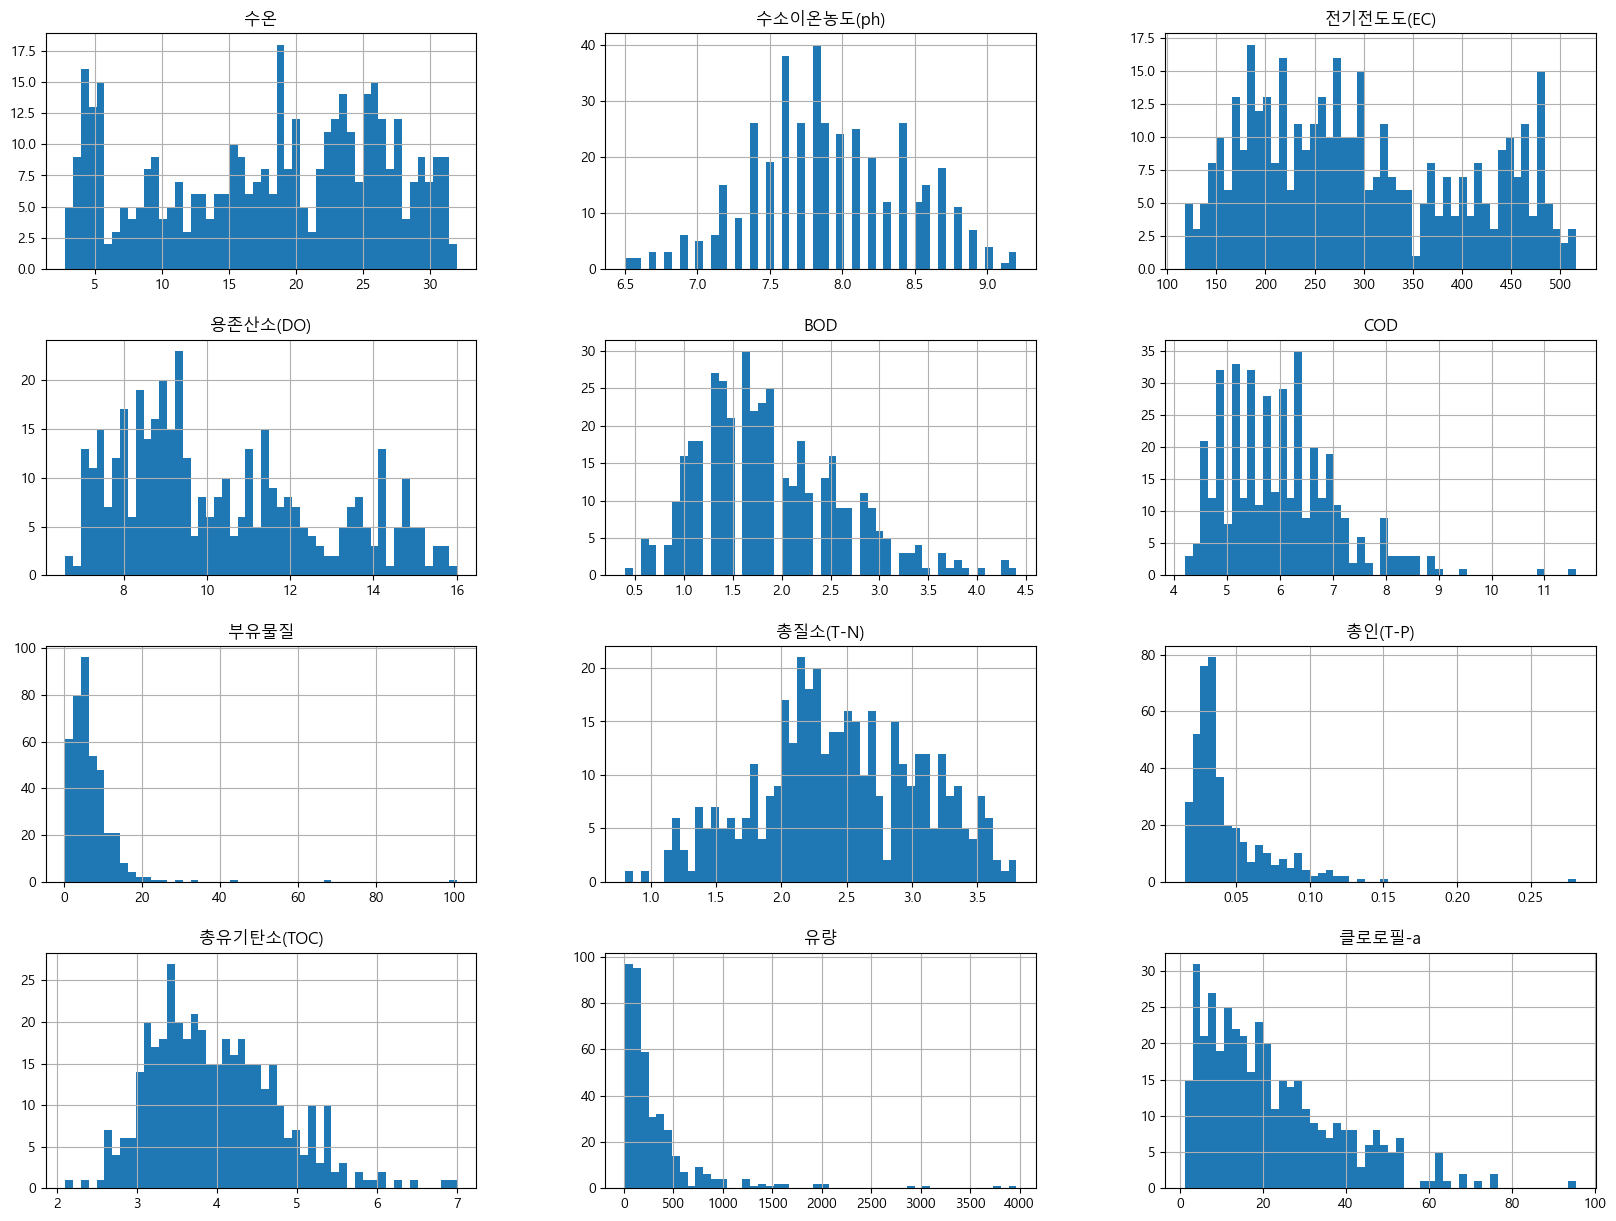

In [62]:
cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']

waterDF[cols].hist(bins=50, figsize=(20,15));

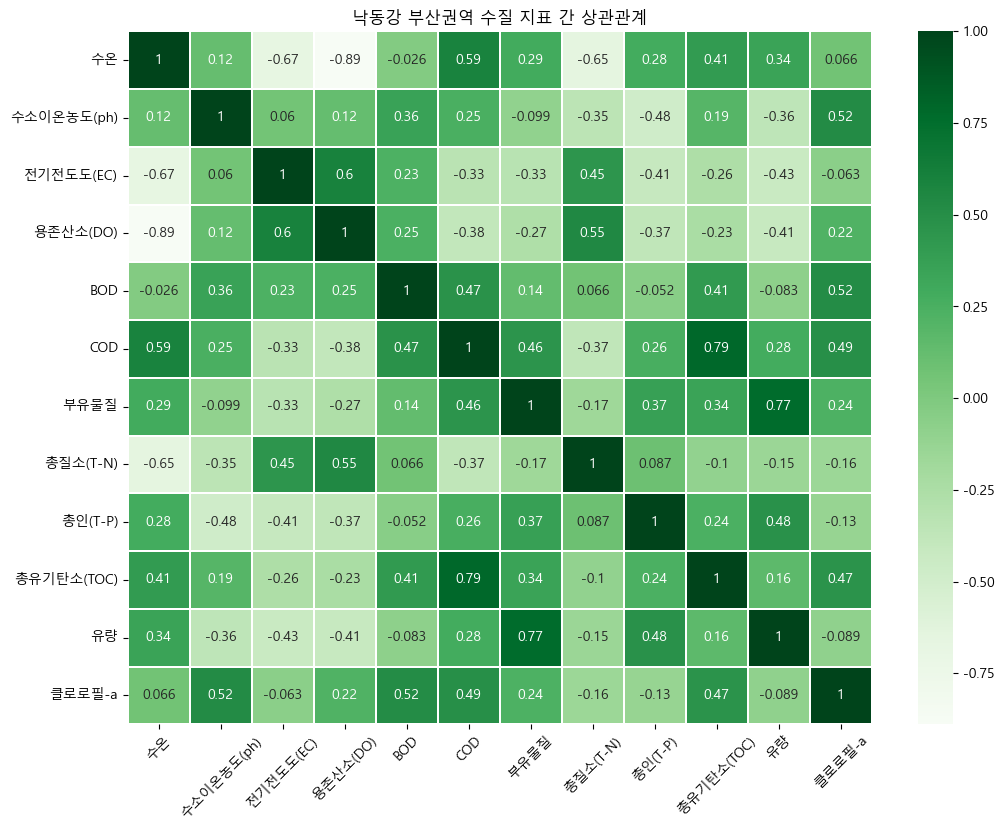

In [63]:
plt.figure(figsize=(12, 9)) 
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=45)
plt.title("낙동강 부산권역 수질 지표 간 상관관계")
plt.show()

In [64]:
### 월 분리
waterDF['월'] = waterDF['일자'].dt.month
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,월
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,1
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,1
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,1
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,9
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6,9
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5,10
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4,10


In [65]:
# 6-9월 추출
summerDF = waterDF[waterDF['월'].between(6, 9)]
summerDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,월
20,물금,2021-06-01,24.3,8.4,295.0,9.2,1.9,6.0,4.0,2.197,0.016,4.2,311.005,24.1,6
21,물금,2021-06-22,26.7,8.7,272.0,9.0,3.0,7.0,6.0,1.717,0.022,4.8,353.580,30.8,6
22,물금,2021-06-14,25.7,8.1,290.0,8.7,1.8,6.6,6.4,1.886,0.047,4.3,130.690,39.4,6
23,물금,2021-06-08,26.9,8.7,291.0,10.0,2.5,7.1,5.6,1.933,0.015,4.5,191.250,25.9,6
24,물금,2021-07-12,26.2,7.2,135.0,7.7,1.1,7.9,30.0,2.310,0.084,5.1,2009.616,12.1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,금곡,2025-08-18,30.7,7.9,166.0,9.0,2.7,6.5,6.0,2.524,0.093,3.9,418.950,27.3,8
399,금곡,2025-09-01,30.4,8.9,188.0,8.9,1.8,8.1,10.0,1.609,0.054,3.4,307.440,38.1,9
400,금곡,2025-09-15,28.8,8.6,275.0,9.7,2.2,8.3,7.2,1.758,0.055,3.9,184.660,48.9,9
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,9


In [66]:
# 추출 결과 확인
summerDF['월'].value_counts().sort_index()

월
6    39
7    34
8    32
9    37
Name: count, dtype: int64

In [67]:
summerDF.describe(include='number')

,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,월
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,142.000000
mean,26.909286,7.871429,223.771429,8.201429,1.951429,6.845714,10.622857,1.970179,0.056457,4.400000,586.976107,23.067143,7.471831
std,2.561640,0.672725,72.049977,0.898198,0.774549,1.109759,10.878983,0.513912,0.029535,0.792864,652.057249,15.831480,1.152817
min,21.800000,6.500000,118.000000,6.600000,0.600000,4.600000,1.200000,0.804000,0.015000,2.100000,121.057000,2.900000,6.000000
25%,25.000000,7.400000,170.000000,7.500000,1.375000,6.100000,5.600000,1.576500,0.033000,3.800000,211.051750,10.300000,6.000000
50%,26.600000,7.850000,206.000000,8.100000,1.800000,6.750000,8.000000,2.019500,0.049500,4.300000,359.459000,20.350000,7.000000
75%,29.100000,8.400000,272.000000,8.800000,2.500000,7.325000,11.700000,2.307750,0.073250,4.800000,650.100000,29.575000,9.000000
max,32.000000,9.200000,480.000000,11.400000,4.400000,11.600000,100.800000,3.567000,0.153000,7.000000,3968.940000,95.500000,9.000000


In [68]:
numDF = summerDF.select_dtypes(include='number')
numDF.describe().T

,count,mean,std,min,25%,50%,75%,max
수온,140.0,26.909286,2.561640,21.800,25.00000,26.6000,29.10000,32.000
수소이온농도(ph),140.0,7.871429,0.672725,6.500,7.40000,7.8500,8.40000,9.200
전기전도도(EC),140.0,223.771429,72.049977,118.000,170.00000,206.0000,272.00000,480.000
용존산소(DO),140.0,8.201429,0.898198,6.600,7.50000,8.1000,8.80000,11.400
BOD,140.0,1.951429,0.774549,0.600,1.37500,1.8000,2.50000,4.400
COD,140.0,6.845714,1.109759,4.600,6.10000,6.7500,7.32500,11.600
부유물질,140.0,10.622857,10.878983,1.200,5.60000,8.0000,11.70000,100.800
총질소(T-N),140.0,1.970179,0.513912,0.804,1.57650,2.0195,2.30775,3.567
총인(T-P),140.0,0.056457,0.029535,0.015,0.03300,0.0495,0.07325,0.153
총유기탄소(TOC),140.0,4.400000,0.792864,2.100,3.80000,4.3000,4.80000,7.000


In [69]:
summerDF.isna().sum().sort_values(ascending=False)

수온            2
수소이온농도(ph)    2
전기전도도(EC)     2
용존산소(DO)      2
BOD           2
COD           2
부유물질          2
총질소(T-N)      2
총인(T-P)       2
총유기탄소(TOC)    2
유량            2
클로로필-a        2
총량지점명         0
일자            0
월             0
dtype: int64

In [70]:
num_cols = [
    '수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)',
    'BOD', 'COD', '부유물질',
    '총질소(T-N)', '총인(T-P)',
    '총유기탄소(TOC)', '유량', '클로로필-a'
]

summer_num = summerDF[num_cols]
summer_num.describe().T

,count,mean,std,min,25%,50%,75%,max
수온,140.0,26.909286,2.561640,21.800,25.00000,26.6000,29.10000,32.000
수소이온농도(ph),140.0,7.871429,0.672725,6.500,7.40000,7.8500,8.40000,9.200
전기전도도(EC),140.0,223.771429,72.049977,118.000,170.00000,206.0000,272.00000,480.000
용존산소(DO),140.0,8.201429,0.898198,6.600,7.50000,8.1000,8.80000,11.400
BOD,140.0,1.951429,0.774549,0.600,1.37500,1.8000,2.50000,4.400
COD,140.0,6.845714,1.109759,4.600,6.10000,6.7500,7.32500,11.600
부유물질,140.0,10.622857,10.878983,1.200,5.60000,8.0000,11.70000,100.800
총질소(T-N),140.0,1.970179,0.513912,0.804,1.57650,2.0195,2.30775,3.567
총인(T-P),140.0,0.056457,0.029535,0.015,0.03300,0.0495,0.07325,0.153
총유기탄소(TOC),140.0,4.400000,0.792864,2.100,3.80000,4.3000,4.80000,7.000


In [71]:
# 현재 지점명 확인
print("지점 목록:", summerDF['총량지점명'].unique())

지점 목록: ['물금' '금곡']


In [72]:
# '물금', '금곡' 자동 매칭 (부분 일치)
mulgum_name = summerDF.loc[summerDF['총량지점명'].astype(str).str.contains('물금'), '총량지점명'].unique()
geumgok_name = summerDF.loc[summerDF['총량지점명'].astype(str).str.contains('금곡'), '총량지점명'].unique()

In [73]:
print("물금 매칭:", mulgum_name)
print("금곡 매칭:", geumgok_name)

물금 매칭: ['물금']
금곡 매칭: ['금곡']


In [74]:
#  실제 사용할 이름(첫 번째) 선택
mulgum = mulgum_name[0]
geumgok = geumgok_name[0]

In [75]:
summer_mulgum = summerDF[summerDF['총량지점명'] == mulgum].copy()
summer_geumgok = summerDF[summerDF['총량지점명'] == geumgok].copy()


In [76]:
print(len(summer_mulgum), len(summer_geumgok))

81 61


In [77]:
summer_mulgum[num_cols].dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
수온,79.0,27.156962,2.629940,22.200,25.0500,27.000,29.200,32.000
수소이온농도(ph),79.0,7.905063,0.674613,6.600,7.4000,8.100,8.400,9.200
전기전도도(EC),79.0,222.582278,69.822230,124.000,170.0000,205.000,272.000,410.000
용존산소(DO),79.0,8.164557,0.806868,6.600,7.5000,8.100,8.700,10.100
BOD,79.0,1.963291,0.758402,0.900,1.4000,1.800,2.350,4.400
COD,79.0,6.900000,1.155367,4.600,6.1500,6.800,7.500,11.600
부유물질,79.0,11.235443,13.155822,1.200,5.8000,8.000,11.800,100.800
총질소(T-N),79.0,1.939076,0.531358,0.804,1.5420,1.948,2.267,3.567
총인(T-P),79.0,0.056848,0.030626,0.015,0.0345,0.050,0.073,0.153
총유기탄소(TOC),79.0,4.441772,0.764368,2.500,3.8000,4.500,4.950,7.000


In [78]:
summer_geumgok[num_cols].dropna().describe().T

,count,mean,std,min,25%,50%,75%,max
수온,61.0,26.588525,2.454594,21.800,25.000,26.100,28.600,32.000
수소이온농도(ph),61.0,7.827869,0.673333,6.500,7.400,7.800,8.400,9.000
전기전도도(EC),61.0,225.311475,75.394416,118.000,173.000,207.000,271.000,480.000
용존산소(DO),61.0,8.249180,1.009228,6.700,7.400,8.000,9.000,11.400
BOD,61.0,1.936066,0.801048,0.600,1.300,1.800,2.600,4.000
COD,61.0,6.775410,1.053036,4.900,6.100,6.600,7.300,10.900
부유물질,61.0,9.829508,6.931843,2.000,5.600,8.000,11.200,43.200
총질소(T-N),61.0,2.010459,0.491812,1.123,1.603,2.037,2.323,3.223
총인(T-P),61.0,0.055951,0.028302,0.017,0.032,0.049,0.075,0.119
총유기탄소(TOC),61.0,4.345902,0.831580,2.100,3.700,4.200,4.700,6.900


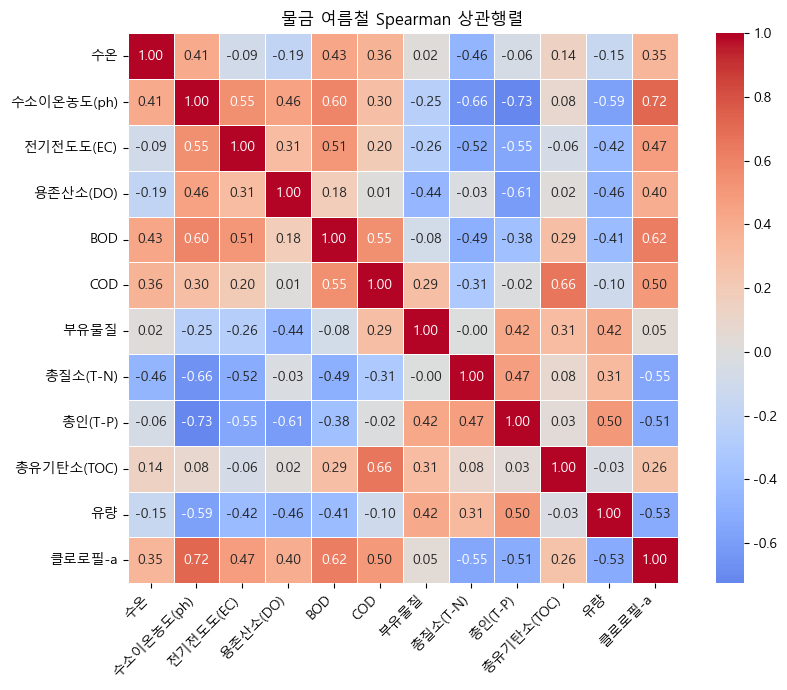

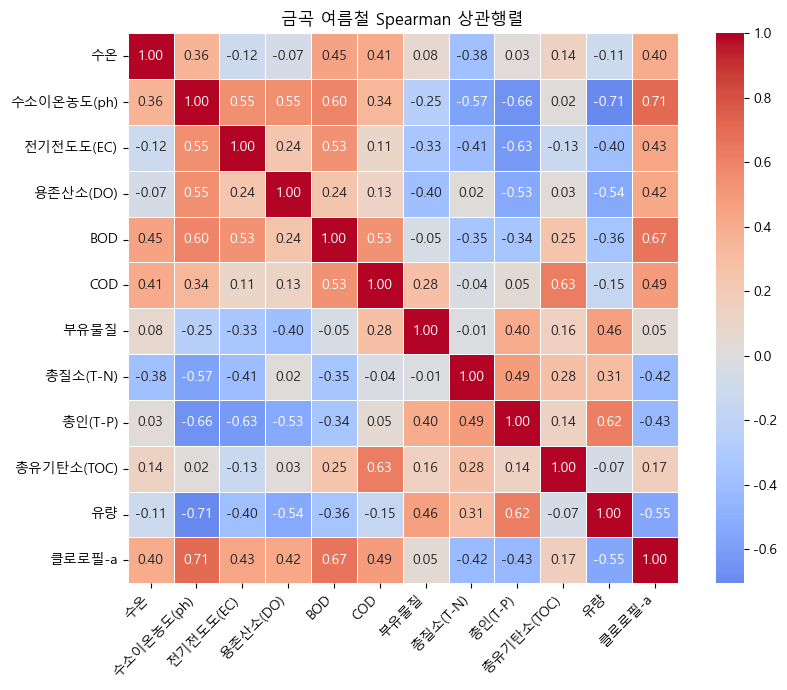

In [79]:
def corr_heatmap(df, title):
    c = df[num_cols].dropna().corr(method='spearman')
    plt.figure(figsize=(9,7))
    sb.heatmap(c, annot=True, fmt=".2f", center=0, square=True, linewidths=0.5, cmap="coolwarm")
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

corr_heatmap(summer_mulgum, f'{mulgum} 여름철 Spearman 상관행렬')
corr_heatmap(summer_geumgok, f'{geumgok} 여름철 Spearman 상관행렬')


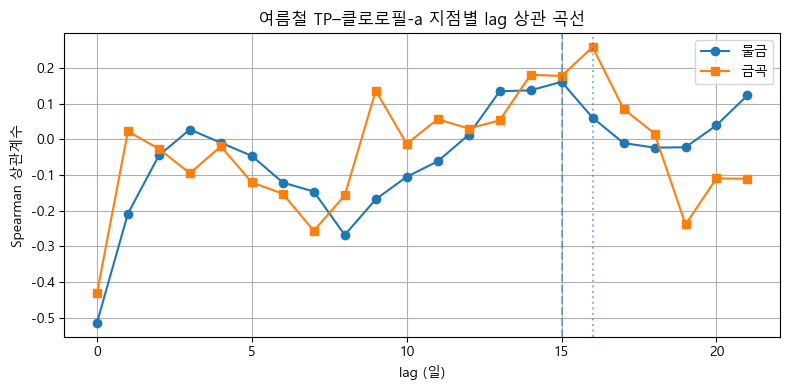

물금 최고 lag: 15 상관: 0.16088177012000254
금곡 최고 lag: 16 상관: 0.25813677747421593


In [80]:
def lag_corr_curve(df, driver='총인(T-P)', target='클로로필-a', max_lag=21, method='spearman'):
    g = df[['일자', driver, target]].dropna().sort_values('일자')
    lags = np.arange(0, max_lag + 1, 1)
    corrs = []
    for lag in lags:
        x = g[driver]
        y = g[target].shift(-lag)   # driver가 먼저, target이 나중(미래)
        corr = pd.concat([x, y], axis=1).dropna().corr(method=method).iloc[0,1]
        corrs.append(corr)
    return lags, corrs

lags, corr_mulgum = lag_corr_curve(summer_mulgum, driver='총인(T-P)', target='클로로필-a', max_lag=21)
_,    corr_geumgok = lag_corr_curve(summer_geumgok, driver='총인(T-P)', target='클로로필-a', max_lag=21)

plt.figure(figsize=(8,4))
plt.plot(lags, corr_mulgum, marker='o', label=mulgum)
plt.plot(lags, corr_geumgok, marker='s', label=geumgok)

# 최고점 lag 표시
plt.axvline(lags[np.nanargmax(corr_mulgum)], linestyle='--', alpha=0.5)
plt.axvline(lags[np.nanargmax(corr_geumgok)], linestyle=':',  alpha=0.5)

plt.xlabel('lag (일)')
plt.ylabel('Spearman 상관계수')
plt.title('여름철 TP–클로로필-a 지점별 lag 상관 곡선')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{mulgum} 최고 lag:", int(lags[np.nanargmax(corr_mulgum)]), "상관:", float(np.nanmax(corr_mulgum)))
print(f"{geumgok} 최고 lag:", int(lags[np.nanargmax(corr_geumgok)]), "상관:", float(np.nanmax(corr_geumgok)))


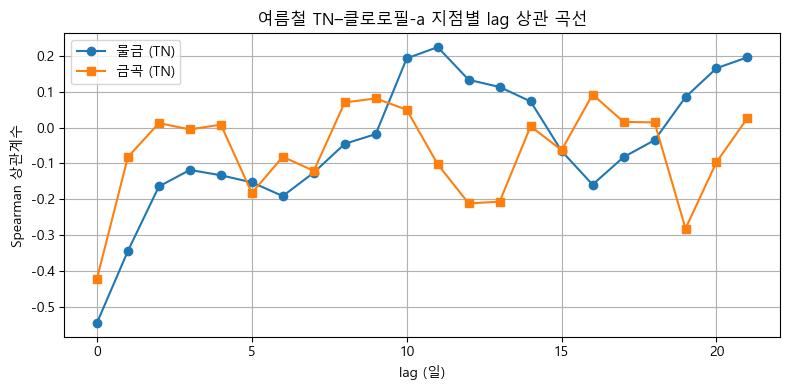

In [81]:
lags, corr_mulgum_TN = lag_corr_curve(summer_mulgum, driver='총질소(T-N)', target='클로로필-a', max_lag=21)
_,    corr_geumgok_TN = lag_corr_curve(summer_geumgok, driver='총질소(T-N)', target='클로로필-a', max_lag=21)

plt.figure(figsize=(8,4))
plt.plot(lags, corr_mulgum_TN, marker='o', label=f'{mulgum} (TN)')
plt.plot(lags, corr_geumgok_TN, marker='s', label=f'{geumgok} (TN)')
plt.xlabel('lag (일)')
plt.ylabel('Spearman 상관계수')
plt.title('여름철 TN–클로로필-a 지점별 lag 상관 곡선')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
